In [1]:
import time
import optuna
import joblib
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, precision_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Definindo a seed para o random state
rs = 840

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Lendo os dados
data_fraud = pd.read_csv("../data/processed/data_fraud.csv", index_col=0)

In [3]:
# Dividindo em variáveis explicativas e target
x = data_fraud.drop(["score_fraude_modelo", "fraude"], axis = 1)
y = data_fraud["fraude"]

Vamos relembrar pontos importantes que descobrimos na etapa de análise:

- As variáveis **pais** e **categoria_produto** possuem uma alta cardinalidade.
- As variáveis **pais** e **categoria_produto** possuem muitos valores com contagem de categorias iguais.
- Ainda existem variáveis com valores ausentes, tanto categóricas, como numéricas.
- O target está desbalanceado.

Sabendo disso, vamos desenhar como a etapa de experimentação irá se desenrolar:

1. Os dados serão divididos em treino, dev e teste. Iremos treinar o algoritmo
com os dados de treino, fazer a tunagem com os dados de dev, e, por fim, validar
com os dados de teste.
2. Será criado um esqueleto para o pipeline de transformação, consistindo
em um imputer e scaler(quando necessário) para as variáveis numéricas e um imputer 
e um encoder para as categóricas.
    
    2.1. Não usaremos o OneHotEncoder para as colunas com uma alta quantidade de
    categorias únicas, pois isso elevaria a dimensionalidade dos dados.

    2.2. Também não será utilizado o CountEncoder nas colunas com uma alta quantidade
    de categorias únicas, pois algumas categorias apresentam a mesma quantidade de registros.

3. A princípio, testaremos alguns modelos base com o StandardScaler (quando necessário),
OneHotEncoder para as features de baixa dimensão e CatBoostEncoder para as de alta
dimensão.
3. As métricas avaliadas serão o Recall e a Latência média.
4. Os modelos mais promissores entrarão em outra rodada de experimentos, dessa
vez para testar outras combinações de encoders e scalers (se necessário).

Agora que sabemos o que fazer, vamos descobrir quais métricas devemos superar.
Para tal, vamos calcular o **recall** e **f1_weighted** das predições do modelo atual, 
assim como ganhos e perdas que tais predições geram. Segue como cada uma será
calculada:

- Perdas: o valor de compra de todos os falsos negativos (fraudes identificadas como compras legítimas) serão somadas.
- Lucro Bruto: o valor de todos os verdadeiros negativos (compras legítimas não identificadas como fraude).
- Lucro líquido: Lucro Bruto - Perdas

Eu também poderia acrescentar os falsos positivos (compras legítimas 
identificadas como fraudulentas), mas como não sei se a compra é cancelada de
vez ou aguarda confirmação adicional por parte do cliente, optarei por não
incluir esses valores.

As métricas serão calculadas a partir dos dados de **teste**.


In [4]:
# Define o local para salvar os exoerimentos
mlflow.set_tracking_uri('../mlruns')

In [5]:
# Divindo os dados em treino, dev e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=rs)

x_dev, x_teste, y_dev, y_teste = train_test_split(x_teste, 
                                                  y_teste,
                                                  stratify=y_teste,
                                                  test_size=0.5,
                                                  random_state=rs)

# Dividindo features numéricas de categóricas
cat_cols_high_dim = ["pais", "categoria_produto"]
cat_cols = [col for col in x_treino.select_dtypes("object").columns if col not in cat_cols_high_dim]
num_cols = x_treino.select_dtypes(["int", "float"]).columns

# Setando o KFold
kf = StratifiedKFold(shuffle=True, random_state=rs)

In [6]:
# Obtendo os dados de métricas
data_metrics = data_fraud.loc[y_teste.index, ["valor_compra", "score_fraude_modelo", "fraude"]]

# Criando uma label com base nos scores do modelo
data_metrics["label_fraude_modelo"] = data_metrics["score_fraude_modelo"].apply(lambda score: 1 if score >= 50 else 0)

# Reduzindo o score para a escala entre 0 e 1
data_metrics["score_fraude_modelo"] = data_metrics["score_fraude_modelo"]/100

In [7]:
data_metrics.head()

,valor_compra,score_fraude_modelo,fraude,label_fraude_modelo
111828,6.39,0.87,0,1
53621,10.41,0.90,0,1
29541,9.98,0.19,0,0
122478,14.10,0.56,0,1
73542,479.30,0.86,0,1


In [8]:
# Calculando as métricas
recall = recall_score(data_metrics["fraude"], data_metrics["label_fraude_modelo"])
f1_weighted = f1_score(data_metrics["fraude"], data_metrics["label_fraude_modelo"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_modelo == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_modelo == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

Com o threshold base (50%), o recall é de:  0.7608888888888888
Com o threshold base (50%), o f1-score weighted é de:  0.6586582569846577
Com o threshold base (50%), as perdas são de:  12690.34
Com o threshold base (50%), os ganhos bruto são de:  42153.344000000005
Com o threshold base (50%), os ganhos líquidos são de:  29463.004000000004


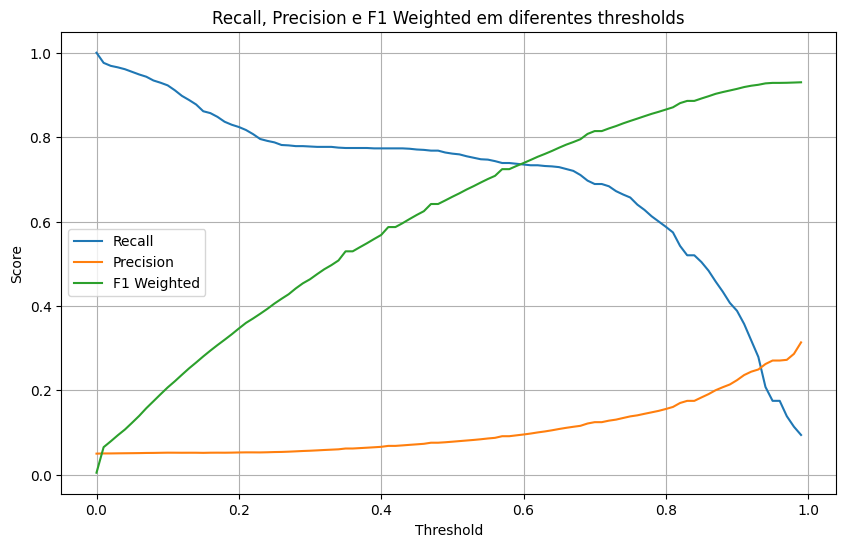

In [9]:
data_dict = {"Threshold":[], 
             "Recall":[],
             "Precision":[],
             "F1 Weighted":[],
             "Ganhos Brutos":[],
             "Perdas":[],
             "Ganhos Líquidos":[]}

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (data_metrics["score_fraude_modelo"] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    f1 = f1_score(y_teste, predictions, average="weighted")
    data_dict["Threshold"].append(threshold)
    data_dict["Recall"].append(recall)
    data_dict["Precision"].append(precision)
    data_dict["F1 Weighted"].append(f1)
    
    data_metrics["label_fraude_modelo"] = predictions
    acertos = data_metrics.query(f"fraude == 0 and label_fraude_modelo == 0")
    erros = data_metrics.query(f"fraude == 1 and label_fraude_modelo == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    data_dict["Ganhos Brutos"].append(ganhos)
    data_dict["Perdas"].append(perdas)
    data_dict["Ganhos Líquidos"].append(diff_ganhos_perdas)
        
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Recall"], label='Recall')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Precision"], label='Precision')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["F1 Weighted"], label='F1 Weighted')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision e F1 Weighted em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Visualizando os dados em forma de tabela
pd.DataFrame(data_dict).sort_values(by="Ganhos Líquidos", ascending=False)

,Threshold,Recall,Precision,F1 Weighted,Ganhos Brutos,Perdas,Ganhos Líquidos
76,0.76,0.640000,0.140762,0.843891,65912.190,19549.98,46362.210
75,0.75,0.656889,0.138260,0.838339,64916.138,18666.09,46250.048
77,0.77,0.627556,0.144376,0.849570,66744.637,20611.54,46133.097
80,0.80,0.587556,0.155786,0.865329,70014.224,23907.04,46107.184
79,0.79,0.600000,0.151379,0.860041,68921.392,22849.33,46072.062
...,...,...,...,...,...,...,...
4,0.04,0.960889,0.050904,0.107224,4596.165,2524.54,2071.625
3,0.03,0.965333,0.050722,0.093628,3830.730,2447.83,1382.900
2,0.02,0.968889,0.050479,0.079154,3133.909,2094.57,1039.339
1,0.01,0.976000,0.050439,0.065304,2313.644,1486.31,827.334


O nosso maior ganho está no Threshold 0.76, onde o lucro líquido foi de 46362.21

## Realizando os experimentos

In [11]:
# Definindo os dicionarios com os modelos e etapas de pre-processamento que serã utilizadas

dict_models_scale_sensitive = {"LR": LogisticRegression(random_state=rs,
                                                        class_weight='balanced')}

dict_models_tree_based = {"LGBM": LGBMClassifier(is_unbalance=True,
                                                 objective= 'binary',
                                                 random_state=rs),
                          "XGB": XGBClassifier(random_state=rs,
                                               objective='binary:hinge'),
                          "RF": RandomForestClassifier(class_weight='balanced',
                                                       random_state=rs)}

# Criando dicionário com os encoders
dict_encoders = {"OHE": OneHotEncoder(drop='first'),
                 "TE": ce.TargetEncoder(),
                 "BE": ce.BinaryEncoder(),
                 "ME": ce.MEstimateEncoder(),
                 "CE": ce.CatBoostEncoder(),
                 "GE":ce.GrayEncoder(),
                 "CTE":ce.CountEncoder()}

dict_imputers_num = {"SIAVG": SimpleImputer(strategy='mean'),
                     "SIMEDIAN": SimpleImputer(strategy='median')}

dict_scalers = {"SS": StandardScaler(),
                "RS": RobustScaler()}

# Criando dicionário com os transformers
dict_transformers = {"PT": PowerTransformer()}

In [12]:
## Criando/acessando o experimento
#mlflow.set_experiment('Comparando modelos base')
#
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_scale_sensitive.items():
#
#    # Gerando a tag de identificação do modelo
#    nome_modelo = f'{tag}'
#
#    with mlflow.start_run(run_name=nome_modelo):
#
#        # Criando os pipeline com os transformers
#        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                            ('encoder', OneHotEncoder(drop='first'))])
#    
#        # Criando os pipeline com os transformers
#        pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                        ('encoder_hd', ce.CatBoostEncoder())])
#    
#        pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
#                            ('scaler', StandardScaler())])
#    
#        # Criando o transformador
#        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                        ('num', pipe_num, num_cols),
#                                        ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                        remainder="passthrough")
#    
#        # Criando o pipeline final
#        pipe = Pipeline([('transformer', transformer),
#                        ('model', model)])
#    
#        # Executando o cross validation
#        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#        # Calculando a média das métricas
#        mean_score = cross_val_scores.mean()           
#    
#        # Salvando a métrica da folder 1
#        mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#        # Salvando a métrica da folder 2
#        mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#        # Salvando a métrica da folder 3
#        mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#        # Salvando a métrica da folder 4
#        mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#        # Salvando a métrica da folder 5
#        mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#        # Salvando as métricas
#        mlflow.log_metric('recall_mean', mean_score)
#        
#        # Salvando o f1 weighted
#        mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#        
#        # Salvando a métrica do f1
#        mlflow.log_metric('f1_weighted_mean', mean_f1)
#    
#        # Treinando o algoritmo
#        pipe.fit(x_treino, y_treino)
#    
#        # Calculando a latência média
#        latency_list = []
#    
#        for _, row in x_treino[:1000].iterrows():
#        
#            # Início da contagem de tempo
#            start_time = time.time()
#    
#            # Extrair os recursos da linha
#            features = row.values.reshape(1, -1)
#    
#            # Fazer a previsão para a linha individual
#            prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#            # Encerra a contagem
#            end_time = time.time()
#            atomic_time = end_time - start_time
#    
#            # Transforma segundo em milissegundo
#            atomic_milissec = atomic_time * 1000
#    
#            # Adiciona o tempo em uma lista
#            latency_list.append(atomic_milissec)
#    
#        # calcula a média 
#        mlflow.log_metric("Latência média", np.mean(latency_list))

In [13]:
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_tree_based.items():
#
#    # Gerando a tag de identificação do modelo
#    nome_modelo = f'{tag}'
#
#    with mlflow.start_run(run_name=nome_modelo):
#
#        # Criando os pipeline com os transformers
#        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                            ('encoder', OneHotEncoder(drop='first'))])
#    
#        # Criando os pipeline com os transformers
#        pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                        ('encoder_hd', ce.CatBoostEncoder())])
#    
#        pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median"))])
#    
#        # Criando o transformador
#        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                        ('num', pipe_num, num_cols),
#                                        ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                        remainder="passthrough")
#    
#        # Criando o pipeline final
#        pipe = Pipeline([('transformer', transformer),
#                        ('model', model)])
#    
#        # Executando o cross validation
#        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#        # Calculando a média das métricas
#        mean_score = cross_val_scores.mean()           
#    
#        # Salvando a métrica da folder 1
#        mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#        # Salvando a métrica da folder 2
#        mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#        # Salvando a métrica da folder 3
#        mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#        # Salvando a métrica da folder 4
#        mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#        # Salvando a métrica da folder 5
#        mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#        # Salvando as métricas
#        mlflow.log_metric('recall_mean', mean_score)
#        
#        # Salvando o f1 weighted
#        mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#        
#        # Salvando a métrica do f1
#        mlflow.log_metric('f1_weighted_mean', mean_f1)
#    
#        # Treinando o algoritmo
#        pipe.fit(x_treino, y_treino)
#    
#        # Calculando a latência média
#        latency_list = []
#    
#        for _, row in x_treino[:1000].iterrows():
#        
#            # Início da contagem de tempo
#            start_time = time.time()
#    
#            # Extrair os recursos da linha
#            features = row.values.reshape(1, -1)
#    
#            # Fazer a previsão para a linha individual
#            prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#            # Encerra a contagem
#            end_time = time.time()
#            atomic_time = end_time - start_time
#    
#            # Transforma segundo em milissegundo
#            atomic_milissec = atomic_time * 1000
#    
#            # Adiciona o tempo em uma lista
#            latency_list.append(atomic_milissec)
#    
#        # calcula a média 
#        mlflow.log_metric("Latência média", np.mean(latency_list))

In [14]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.f1_weighted_mean', 
                       'metrics.recall_mean', 'metrics.Latência média', 
                       'metrics.recall_fold_1', 'metrics.recall_fold_2', 
                       'metrics.recall_fold_3', 'metrics.recall_fold_4', 
                       'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

KeyError: "None of [Index(['tags.mlflow.runName', 'metrics.f1_weighted_mean',\n       'metrics.recall_mean', 'metrics.Latência média',\n       'metrics.recall_fold_1', 'metrics.recall_fold_2',\n       'metrics.recall_fold_3', 'metrics.recall_fold_4',\n       'metrics.recall_fold_5'],\n      dtype='object')] are in the [columns]"

Dos modelos testados, apenas o **LightGBM** e a **Regressão Logística** tiveram
um bom resultado. 

- O **Recall** do **LightGBM** é cerca de **0.5% superior** ao da **Regressão**.
- A **latência** do **LightGBM** é cerca de **76% maior** do que a da **Regressão**.

Vamos tunar e avaliar ambos os modelos.

In [ ]:
## Criando/acessando o experimento
#mlflow.set_experiment('Comparando regressões')
#
## Iniciando os experimentos com regressões
#for tag_encoder, encoder in dict_encoders.items():
#    for tag_scaler, scaler in dict_scalers.items():
#        for tag_imputer, imputer in dict_imputers_num.items():
#        
#            # Gerando a tag de identificação do modelo
#            nome_modelo = f'LR_{tag_encoder}_{tag_scaler}_{tag_imputer}'
#
#            with mlflow.start_run(run_name=nome_modelo):
#            
#                # Criando os pipeline com os transformers
#                pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder', encoder)])
#
#                # Criando os pipeline com os transformers
#                pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                                ('encoder_hd', ce.CatBoostEncoder())])
#
#                pipe_num = Pipeline([('imputer_num', imputer),
#                                     ('scaler', scaler)])
#
#                # Criando o transformador
#                transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                ('num', pipe_num, num_cols),
#                                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                                remainder="passthrough")
#
#                # Criando o pipeline final
#                pipe = Pipeline([('transformer', transformer),
#                                ('model', LogisticRegression(class_weight='balanced',
#                                                             random_state=rs))])
#
#                # Executando o cross validation
#                cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#
#                # Calculando a média das métricas
#                mean_score = cross_val_scores.mean()           
#
#                # Salvando a métrica da folder 1
#                mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#
#                # Salvando a métrica da folder 2
#                mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#
#                # Salvando a métrica da folder 3
#                mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#
#                # Salvando a métrica da folder 4
#                mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#
#                # Salvando a métrica da folder 5
#                mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#
#                # Salvando as métricas
#                mlflow.log_metric('recall_mean', mean_score)
#                
#                # Salvando o f1 weighted
#                mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#                
#                # Salvando a métrica do f1
#                mlflow.log_metric('f1_weighted_mean', mean_f1)
#
#                # Treinando o algoritmo
#                pipe.fit(x_treino, y_treino)
#
#                # Calculando a latência média
#                latency_list = []
#
#                for _, row in x_treino[:1000].iterrows():
#                
#                    # Início da contagem de tempo
#                    start_time = time.time()
#
#                    # Extrair os recursos da linha
#                    features = row.values.reshape(1, -1)
#
#                    # Fazer a previsão para a linha individual
#                    prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#
#                    # Encerra a contagem
#                    end_time = time.time()
#                    atomic_time = end_time - start_time
#
#                    # Transforma segundo em milissegundo
#                    atomic_milissec = atomic_time * 1000
#
#                    # Adiciona o tempo em uma lista
#                    latency_list.append(atomic_milissec)
#
#                # calcula a média 
#                mlflow.log_metric("Latência média", np.mean(latency_list))
#

2024/04/12 09:31:13 INFO mlflow.tracking.fluent: Experiment with name 'Comparando regressões' does not exist. Creating a new experiment.


/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [ ]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.f1_weighted_mean', 
                       'metrics.recall_mean', 'metrics.Latência média', 
                       'metrics.recall_fold_1', 'metrics.recall_fold_2', 
                       'metrics.recall_fold_3', 'metrics.recall_fold_4', 
                       'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.f1_weighted_mean,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
0,LR_CTE_RS_SIMEDIAN,0.690758,0.700571,39.934036,0.721905,0.708571,0.682857,0.685714,0.703810
1,LR_CTE_RS_SIAVG,0.717180,0.699048,45.698645,0.714286,0.706667,0.680952,0.685714,0.707619
7,LR_GE_SS_SIAVG,0.807978,0.673333,51.978545,0.661905,0.677143,0.673333,0.665714,0.688571
17,LR_BE_RS_SIAVG,0.808237,0.673333,56.522726,0.661905,0.678095,0.665714,0.670476,0.690476
18,LR_BE_SS_SIMEDIAN,0.808429,0.672762,56.829186,0.660000,0.673333,0.678095,0.663810,0.688571
24,LR_OHE_RS_SIMEDIAN,0.806843,0.672762,30.154952,0.662857,0.674286,0.674286,0.664762,0.687619
6,LR_GE_SS_SIMEDIAN,0.808443,0.672381,60.197710,0.660952,0.677143,0.669524,0.661905,0.692381
4,LR_GE_RS_SIMEDIAN,0.807141,0.672381,63.011021,0.658095,0.677143,0.669524,0.665714,0.691429
25,LR_OHE_RS_SIAVG,0.806142,0.672190,20.303402,0.656190,0.674286,0.673333,0.665714,0.691429
26,LR_OHE_SS_SIMEDIAN,0.808796,0.672000,25.794318,0.661905,0.676190,0.671429,0.662857,0.687619


In [ ]:
## Criando/acessando o experimento
#mlflow.set_experiment('Comparando lgbms')
#
## Iniciando os experimentos com o lightgbm
#for tag_encoder, encoder in dict_encoders.items():
#        for tag_imputer, imputer in dict_imputers_num.items():
#    
#            # Gerando a tag de identificação do modelo
#            nome_modelo = f'LGBM_{tag_encoder}_{tag_imputer}'
#    
#            with mlflow.start_run(run_name=nome_modelo):
#            
#                # Criando os pipeline com os transformers
#                pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder', encoder)])
#    
#                # Criando os pipeline com os transformers
#                pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                                ('encoder_hd', ce.CatBoostEncoder())])
#    
#                pipe_num = Pipeline([('imputer_num', imputer)])
#    
#                # Criando o transformador
#                transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                ('num', pipe_num, num_cols),
#                                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                                remainder="passthrough")
#    
#                # Criando o pipeline final
#                pipe = Pipeline([('transformer', transformer),
#                                ('model', LGBMClassifier(is_unbalance=True,
#                                                 objective= 'binary',
#                                                 random_state=rs))])
#    
#                # Executando o cross validation
#                cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#                # Calculando a média das métricas
#                mean_score = cross_val_scores.mean()           
#    
#                # Salvando a métrica da folder 1
#                mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#                # Salvando a métrica da folder 2
#                mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#                # Salvando a métrica da folder 3
#                mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#                # Salvando a métrica da folder 4
#                mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#                # Salvando a métrica da folder 5
#                mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#                # Salvando as métricas
#                mlflow.log_metric('recall_mean', mean_score)
#                
#                # Salvando o f1 weighted
#                mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#                
#                # Salvando a métrica do f1
#                mlflow.log_metric('f1_weighted_mean', mean_f1)
#    
#                # Treinando o algoritmo
#                pipe.fit(x_treino, y_treino)
#    
#                # Calculando a latência média
#                latency_list = []
#    
#                for _, row in x_treino[:1000].iterrows():
#                
#                    # Início da contagem de tempo
#                    start_time = time.time()
#    
#                    # Extrair os recursos da linha
#                    features = row.values.reshape(1, -1)
#    
#                    # Fazer a previsão para a linha individual
#                    prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#                    # Encerra a contagem
#                    end_time = time.time()
#                    atomic_time = end_time - start_time
#    
#                    # Transforma segundo em milissegundo
#                    atomic_milissec = atomic_time * 1000
#    
#                    # Adiciona o tempo em uma lista
#                    latency_list.append(atomic_milissec)
#    
#                # calcula a média 
#                mlflow.log_metric("Latência média", np.mean(latency_list))
#    

2024/04/12 10:14:07 INFO mlflow.tracking.fluent: Experiment with name 'Comparando lgbms' does not exist. Creating a new experiment.


[LightGBM] [Info] Number of positive: 4200, number of negative: 79800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050000 -> initscore=-2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Number of positive: 4200, number of negative: 79800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 31
[LightGBM] [Info] [b

In [ ]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.f1_weighted_mean', 
                       'metrics.recall_mean', 'metrics.Latência média', 
                       'metrics.recall_fold_1', 'metrics.recall_fold_2', 
                       'metrics.recall_fold_3', 'metrics.recall_fold_4', 
                       'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.f1_weighted_mean,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
11,LGBM_TE_SIAVG,0.838867,0.643619,62.969607,0.640000,0.642857,0.651429,0.636190,0.647619
7,LGBM_ME_SIAVG,0.838867,0.643619,56.503378,0.640000,0.642857,0.651429,0.636190,0.647619
13,LGBM_OHE_SIAVG,0.837828,0.639619,39.661925,0.632381,0.628571,0.656190,0.639048,0.641905
4,LGBM_CE_SIMEDIAN,0.839450,0.639429,68.224117,0.647619,0.610476,0.660000,0.634286,0.644762
3,LGBM_GE_SIAVG,0.837333,0.639429,64.073688,0.638095,0.629524,0.650476,0.632381,0.646667
2,LGBM_GE_SIMEDIAN,0.839062,0.638667,64.845442,0.632381,0.628571,0.649524,0.632381,0.650476
9,LGBM_BE_SIAVG,0.838539,0.638095,66.973334,0.637143,0.627619,0.642857,0.641905,0.640952
10,LGBM_TE_SIMEDIAN,0.838495,0.636952,61.431783,0.640952,0.623810,0.649524,0.632381,0.638095
6,LGBM_ME_SIMEDIAN,0.838495,0.636952,58.542917,0.640952,0.623810,0.649524,0.632381,0.638095
8,LGBM_BE_SIMEDIAN,0.838933,0.636000,65.299150,0.636190,0.629524,0.632381,0.634286,0.647619


#### Regressão Logística 
A combinação **Logistic Regression** + **CountEncoder** + **RobustSaler** + 
**SimpleImputer(Mediana)** obteve o primeiro lugar com as seguintes estatísticas:
- Recall médio de 0.70
- F1 weighted médio de 0.69 
- Latência média de 39 milissegundos

No geral, são boas métricas, e ele será o modelo escolhido. Entretanto, também
houveram outras combinações que se saíram bem. A combinação 
**Logistic Regression** + **OneHotEncoder** + **RobustSaler** + 
**SimpleImputer(Media)** demonstrou ser promissora:
- Recall médio de 0.67 (0.03 a menos que o primeiro colocado)
- F1 weighted médio de 0.80 (0.10 a mais que o primeiro colocado)
- Latência média de 20 milissegundos (19 milissegundos a menos que o primeiro colocado)

Selecionaremos esses dois modelos para tunar os parâmetros.

#### LightGBM

Para os modelos com base no LightGBM, temos métricas bem semelhantes entre as 
combinações, por isso, selecionaremos aquele com a menor latência dentre os 
5 primeiros:
**LightGBM** + **OneHotEncoder** + **SimpleImputer(Média)**

## Tunando o modelo candidato

Agora que já temos a melhor combinação de preprocessors, vamos buscar a melhor
opção de hiperparâmetros.

Para tal, usaremos o **Optuna**.

Vamos iniciar com a primeira regressão: **Logistic Regression** + **CountEncoder** + **RobustSaler** + 
**SimpleImputer(Mediana)**.

In [17]:
## Criando função para tunar o modelo
#def objective(trial):
#
#    params = {
#        'C': trial.suggest_float('C', 1e-4, 1e+4, log=True),
#        'penalty': trial.suggest_categorical('penalty', [None, 'l2']),
#        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cholesky']),
#        'max_iter': trial.suggest_int('max_iter', 50, 1000),
#        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#        'random_state': rs
#    }
#    
#    # Criando os pipeline com os transformers
#    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                        ('encoder', ce.CountEncoder())])
#
#    # Criando os pipeline com os transformers
#    pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder_hd', ce.CatBoostEncoder())])
#
#    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
#                          ("scaler", RobustScaler())])
#
#    # Criando o transformador
#    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                    ('num', pipe_num, num_cols),
#                                    ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                    remainder="passthrough")
#    
#    # Criando o pipeline final
#    pipe = Pipeline([('transformer', transformer),
#                    ('model', LogisticRegression(**params))])
#
#    # Treinando o modelo com os dados de treino
#    pipe.fit(x_treino, y_treino)
#   
#    recall = recall_score(y_dev, pipe.predict(x_dev))
#    
#    return recall
#
## Criando o estudo de otimização
#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 50)


[I 2024-04-12 15:59:48,722] A new study created in memory with name: no-name-372bc1b2-d0ae-440c-9a60-b263a86e3316
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-04-12 16:00:04,612] Trial 0 finished with value: 0.005333333333333333 and parameters: {'C': 1993.2154892627345, 'penalty': Non

Obtivemos parâmetros que quase zeram a taxa de falsos negativos. Averiguaremos 
melhor durante o teste final, mas me reservarei a selecionar outro conjunto de 
parâmetros que identifiquei no log dos experimentos, pois diferentemente dos
melhores parâmetros encontrados, estes usam regularização, que ajuda a prevenir o 
overfitting. 

In [30]:
# salvando os melhores parâmetros
best_params_l1_v1 = {'C': 0.0003497693165590731,
                    'penalty': None,
                    'solver': 'saga',
                    'max_iter': 224,
                    'fit_intercept': False,
                    'class_weight': 'balanced',
                    'random_state': rs}

best_params_l1_v2 = {'C': 1789.4428651327607, 
                      'penalty': 'l2', 
                      'solver': 'saga', 
                      'max_iter': 694, 
                      'fit_intercept': True, 
                      'class_weight': 'balanced',
                      'random_state':rs}

In [31]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', ce.CountEncoder())])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                        ("scaler", RobustScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe_logistica_1_v1 = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**best_params_l1_v1))])

# Treinando o modelo com os dados de treino
pipe_logistica_1_v1.fit(x_treino, y_treino)

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   CountEncoder(combine_min_nan_groups=True))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_compra']),...
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=0.0003497693165590731,
                                    class_weight='balanced',
                                    fit_intercept=False, max_iter=224,
                                    penalty=None, random_state=840,
                                    solver='saga'))])

In [32]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', ce.CountEncoder())])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                        ("scaler", RobustScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe_logistica_1_v2 = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**best_params_l1_v2))])

# Treinando o modelo com os dados de treino
pipe_logistica_1_v2.fit(x_treino, y_treino)

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   CountEncoder(combine_min_nan_groups=True))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_compra']),...
       'score_7', 'score_8', 'score_9', 'score_10', 'entrega_doc_1',
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=1789.4428651327607,
                                    class_weight='balanced', max_iter=694,
                                    random_state=840, solver='saga'))])

Agora, vamos testar a segunda: **Logistic Regression** + **OneHotEncoder** + **RobustSaler** + 
**SimpleImputer(Media)**.

In [33]:
# Criando função para tunar o modelo
def objective(trial):

    params = {
        'C': trial.suggest_float('C', 1e-4, 1e+4, log=True),
        'penalty': trial.suggest_categorical('penalty', [None, 'l2']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cholesky']),
        'max_iter': trial.suggest_int('max_iter', 50, 1000),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': rs
    }
    
    # Criando os pipeline com os transformers
    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                        ('encoder', OneHotEncoder(drop='first'))])

    # Criando os pipeline com os transformers
    pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                    ('encoder_hd', ce.CatBoostEncoder())])

    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="mean")),
                        ('scaler', RobustScaler())])

    # Criando o transformador
    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                    ('num', pipe_num, num_cols),
                                    ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                    remainder="passthrough")
    
    # Criando o pipeline final
    pipe = Pipeline([('transformer', transformer),
                    ('model', LogisticRegression(**params))])

    # Treinando o modelo com os dados de treino
    pipe.fit(x_treino, y_treino)
   
    recall = recall_score(y_dev, pipe.predict(x_dev))
    
    return recall

# Criando o estudo de otimização
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50)


[I 2024-04-12 16:51:30,165] A new study created in memory with name: no-name-1c824317-15b5-4c22-be94-40fab415489d
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-04-12 16:52:22,398] Trial 0 finished with value: 0.0 and parameters: {'C': 21.713037031707483, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 349, 'fit_intercept': False, 'class_weight': None}. Best is trial 0 with value: 0.0.
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian

In [ ]:
study.best_params

In [30]:
best_params_l2 = {'C': 0.00010412571220790058, 
                'penalty': 'l2', 
                'solver': 'saga', 
                'max_iter': 668, 
                'fit_intercept': False, 
                'class_weight': 'balanced',
                'random_state':rs}

In [31]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                    ('scaler', StandardScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe_logistica_2 = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**best_params_l2))])

# Treinando o modelo com os dados de treino
pipe_logistica_2.fit(x_treino, y_treino)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_...
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=0.00010412571220790058,
                                    class_weight='balanced',
                                    fit_intercept=False, max_iter=668,
                                    random_state=840, solver='saga'))])

E finalmente, vamos à ultima combinação: **LightGBM** + **OneHotEncoder** + **SimpleImputer(Média)**.

In [29]:
paramsxgb = {'n_estimators': 226,
 'learning_rate': 0.24648438544316717,
 'max_depth': 7,
 'subsample': 0.6835401307831506,
 'colsample_bytree': 0.8125214901314792,
 'reg_alpha': 9.520719398813776,
 'reg_lambda': 4.946735056145298,
'random_state':rs}

In [51]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                    ('scaler', StandardScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipexgb = Pipeline([('transformer', transformer),
                ('model', LGBMClassifier(is_unbalance=True,
                                                 objective= 'binary',
                                                 random_state=rs))])

# Treinando o modelo com os dados de treino
pipexgb.fit(x_treino, y_treino)

[LightGBM] [Info] Number of positive: 5250, number of negative: 99750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2757
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050000 -> initscore=-2.944439
[LightGBM] [Info] Start training from score -2.944439


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_...
                                                  Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'score_7', 'score_8', 'score_9', 'score_10', 'entrega_doc_1',
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LGBMClassifier(is_unbalance=True, objective='binary',
                                random_state=840))])

In [52]:
# Calculando o recall
print(recall_score(y_teste, pipexgb.predict(x_teste)))
print(f1_score(y_teste, pipexgb.predict(x_teste), average="weighted"))

0.664
0.8368105205162732


In [34]:
# Calculando o recall
print(recall_score(y_teste, pipe.predict(x_teste)))
print(f1_score(y_teste, pipe.predict(x_teste), average="weighted"))

0.6471111111111111
0.8006417475071521


## Comprando modelos

Podemos ver que o modelo atual possui um desempenho melhor em evitar falsos 
positivos.

Vamos adicionar métricas financeiras para melhorar a análise. Vamos relembrar:
- A cada aprovação correta, recebemos 10% do valor.
- A cada fraude aprovada, perdemos 100% do valor.

In [53]:
data_metrics["label_fraude_novo_modelo"] = pipexgb.predict(x_teste)
data_metrics["score_fraude_novo_modelo"] = pipexgb.predict_proba(x_teste)[:, 1]

In [54]:
# Calculando as métricas
recall = recall_score(data_metrics["fraude"], data_metrics["label_fraude_novo_modelo"])
f1_weighted = f1_score(data_metrics["fraude"], data_metrics["label_fraude_novo_modelo"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_novo_modelo == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_novo_modelo == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

Com o threshold base (50%), o recall é de:  0.664
Com o threshold base (50%), o f1-score weighted é de:  0.8368105205162732
Com o threshold base (50%), as perdas são de:  15101.95
Com o threshold base (50%), os ganhos bruto são de:  59328.899000000005
Com o threshold base (50%), os ganhos líquidos são de:  44226.94900000001


Ganhos Líquidos = 46362.210

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


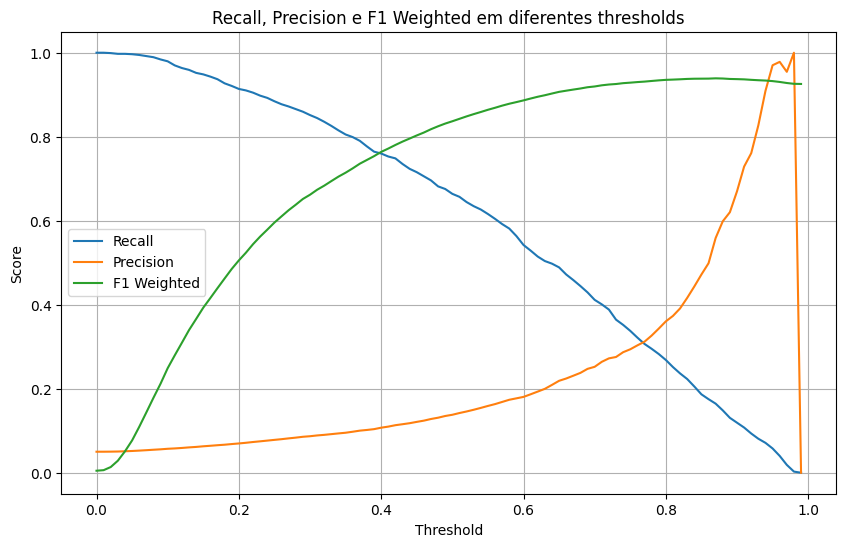

In [55]:
data_dict = {"Threshold":[], 
             "Recall":[],
             "Precision":[],
             "F1 Weighted":[],
             "Ganhos Brutos":[],
             "Perdas":[],
             "Ganhos Líquidos":[]}

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (data_metrics["score_fraude_novo_modelo"] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    f1 = f1_score(y_teste, predictions, average="weighted")
    data_dict["Threshold"].append(threshold)
    data_dict["Recall"].append(recall)
    data_dict["Precision"].append(precision)
    data_dict["F1 Weighted"].append(f1)
    
    data_metrics["label_fraude_novo_modelo"] = predictions
    acertos = data_metrics.query(f"fraude == 0 and label_fraude_novo_modelo == 0")
    erros = data_metrics.query(f"fraude == 1 and label_fraude_novo_modelo == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    data_dict["Ganhos Brutos"].append(ganhos)
    data_dict["Perdas"].append(perdas)
    data_dict["Ganhos Líquidos"].append(diff_ganhos_perdas)
        
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Recall"], label='Recall')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Precision"], label='Precision')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["F1 Weighted"], label='F1 Weighted')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision e F1 Weighted em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Visualizando os dados em forma de tabela
pd.DataFrame(data_dict).sort_values(by="Ganhos Líquidos", ascending=False)

,Threshold,Recall,Precision,F1 Weighted,Ganhos Brutos,Perdas,Ganhos Líquidos
68,0.68,0.444444,0.237756,0.914819,75491.945,25932.14,49559.805
65,0.65,0.488889,0.218862,0.906826,73321.485,23838.09,49483.395
67,0.67,0.458667,0.230976,0.912273,74648.887,25195.20,49453.687
66,0.66,0.472000,0.224335,0.909590,73874.218,24503.60,49370.618
64,0.64,0.497778,0.209111,0.902855,72443.900,23230.17,49213.730
...,...,...,...,...,...,...,...
4,0.04,0.997333,0.051079,0.050909,1265.073,38.95,1226.123
3,0.03,0.997333,0.050481,0.028589,596.902,38.95,557.952
2,0.02,0.999111,0.050179,0.013537,250.757,6.20,244.557
1,0.01,1.000000,0.050033,0.006097,30.749,0.00,30.749


Agora, vamos fazer o mesmo com as predições do modelo atual:

/tmp/ipykernel_9617/2854574763.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conjunto_teste[f"predict_threshold_{str(threshold).replace('.', '_')}"] = predictions
/tmp/ipykernel_9617/2854574763.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conjunto_teste[f"predict_threshold_{str(threshold).replace('.', '_')}"] = predictions
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no

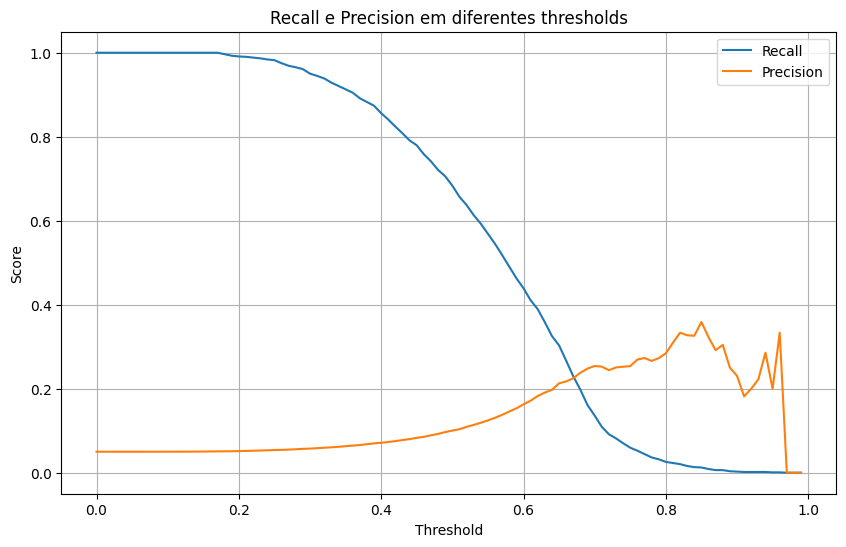

In [21]:
# Definindo listas vazias
thresholds = []
recall_list = []
precision_list = []
earnings = []
loses = []
diff_earnings_loses = []

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (pipe.predict_proba(x_teste)[:, 1] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    recall_list.append(recall)
    precision_list.append(precision)
    thresholds.append(threshold)
    
    conjunto_teste[f"predict_threshold_{str(threshold).replace('.', '_')}"] = predictions
    acertos = conjunto_teste.query(f"fraude == 0 and predict_threshold_{str(threshold).replace('.', '_')} == 0")
    erros = conjunto_teste.query(f"fraude == 1 and predict_threshold_{str(threshold).replace('.', '_')} == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    earnings.append(ganhos)
    loses.append(perdas)
    diff_earnings_loses.append(diff_ganhos_perdas)
    
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=recall_list, label='Recall')
sns.lineplot(x=thresholds, y=precision_list, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall e Precision em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Criando um dataframe com os dados
data_metrics = pd.DataFrame({'Thresholds': thresholds, 
                             "Recall":recall_list, 
                             "Precision":precision_list,
                             "Ganho_Bruto":earnings,
                             "Perdas_Com_Fraudes":loses,
                             "Ganho_Líquido":diff_earnings_loses})

In [23]:
# Ordenando pelo modelo que mais trouxe ganhos totais
data_metrics.sort_values("Ganho_Líquido", ascending=False)

,Thresholds,Recall,Precision,Ganho_Bruto,Perdas_Com_Fraudes,Ganho_Líquido
62,0.62,0.389333,0.182652,68438.636,28984.77,39453.866
63,0.63,0.358222,0.190905,69812.134,30540.60,39271.534
57,0.57,0.518222,0.137792,59685.895,21415.16,38270.735
58,0.58,0.490667,0.145723,61813.399,23544.99,38268.409
61,0.61,0.410667,0.171492,66761.063,28499.29,38261.773
...,...,...,...,...,...,...
3,0.03,1.000000,0.050002,3.308,0.00,3.308
4,0.04,1.000000,0.050002,3.308,0.00,3.308
1,0.01,1.000000,0.050000,0.000,0.00,0.000
2,0.02,1.000000,0.050000,0.000,0.00,0.000


O modelo com o threshold de 0.62 foi o que mais trouxe ganho dado apenas o conjunto
de validação.

Agora que já temos o melhor modelo, e sabemos qual o threshold que vai trazer o 
maior retorno, vamos criar uma API que poderia ser acoplada ao um sistema de
transações. 

In [19]:
joblib.dump(pipe, "../models/logistica.pkl")

['../models/logistica.pkl']